In [1]:
import sys, os
sys.path.append(os.path.abspath("..")) 

from src.insurer_model import Insurer
from src.insurer_model import run_simulation 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
irp_merged = pd.read_csv('../data/processed/irp_merged.csv')
bond_yields = pd.read_csv("../data/processed/bond_yields_merged.csv")

irp_merged["date"] = pd.to_datetime(irp_merged["date"]).dt.normalize()
irp_merged = irp_merged.set_index("date").sort_index()

bond_yields["date"] = pd.to_datetime(bond_yields["date"]).dt.normalize()
bond_yields = bond_yields.set_index("date").sort_index()

df_data = pd.merge(bond_yields, irp_merged, on='date', how='inner')


## Simulation 1: General hedge ratio v forward tenors scenerios (normal period vs stress periods)

## Running simulation during stress period (early 2025 - June 2025, high fx volatility)

In [3]:
def create_insurer(name, hedge_ratio):
    initial_date = df_data.index[0]
    initial_spot = df_data.loc[initial_date, 'spot']
    initial_us_yield = df_data.loc[initial_date, 'yield_10Y']
    
    return Insurer(
        name=name,
        total_assets_twd=10e12,
        foreign_asset_ratio=0.70,
        usd_denom_ratio=0.90,
        initial_twd_usd_spot=initial_spot,
        initial_us_bond_yield=initial_us_yield,
        initial_twd_equity=2.5e12,
        initial_fevr_balance=220e9,
        bond_duration=10,
        hedge_ratio=hedge_ratio
    )

/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, pd.DataFrame([{
/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, pd.DataFrame([{
/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:190: FutureWarning: Th

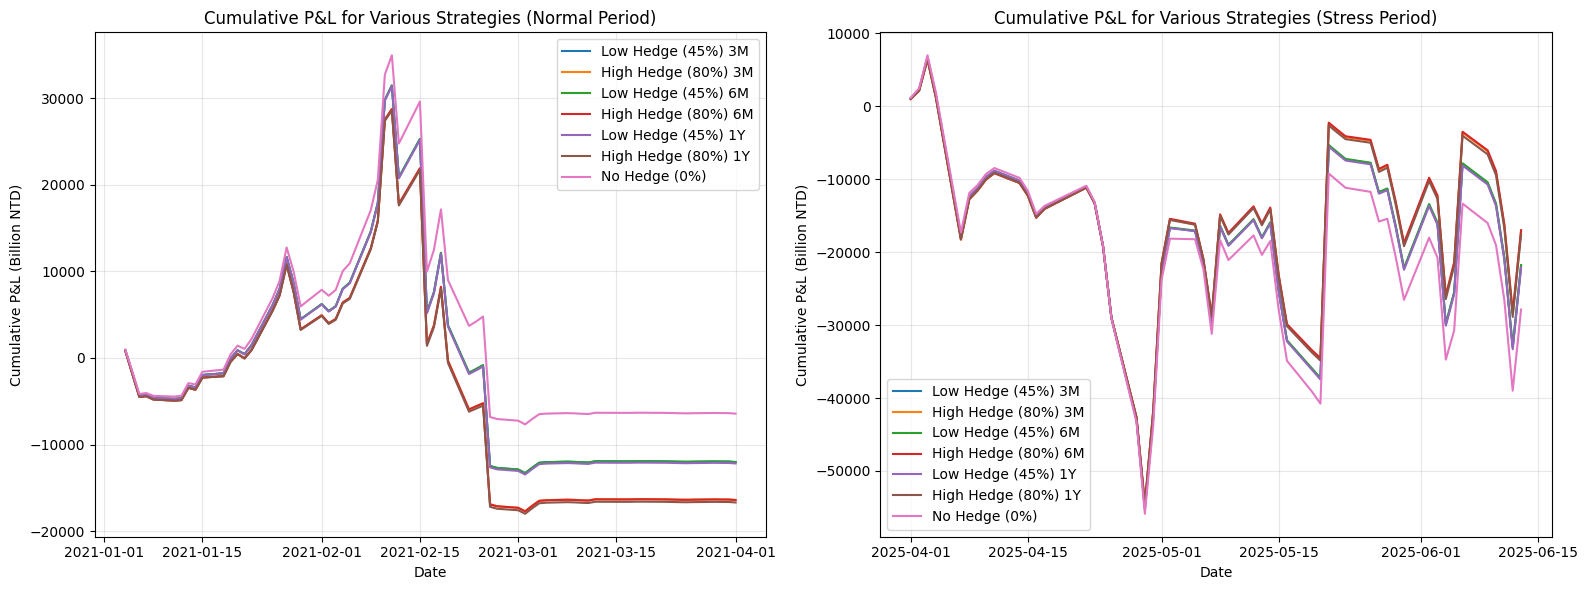

In [4]:
df_normal = df_data.loc['2021-01-04':'2025-01-01'].copy()

# 2.2 Define and Run Strategies to Compare
strategies = {
    'Low Hedge (45%) 3M': {'hedge_ratio': 0.45, 'forward_col': 'forward_3m', 'tenor': 3},
    'High Hedge (80%) 3M': {'hedge_ratio': 0.80, 'forward_col': 'forward_3m', 'tenor': 3},
    'Low Hedge (45%) 6M': {'hedge_ratio': 0.45, 'forward_col': 'forward_6m', 'tenor': 6},
    'High Hedge (80%) 6M': {'hedge_ratio': 0.80, 'forward_col': 'forward_6m', 'tenor': 6},
    'Low Hedge (45%) 1Y': {'hedge_ratio': 0.45, 'forward_col': 'forward_3m', 'tenor': 12},
    'High Hedge (80%) 1Y': {'hedge_ratio': 0.80, 'forward_col': 'forward_3m', 'tenor': 12},

    'No Hedge (0%)': {'hedge_ratio': 0.0, 'forward_col': None, 'tenor': 0}
}

normal_results = {}
for name, params in strategies.items():
    insurer_model = create_insurer(name, params['hedge_ratio'])
    history = run_simulation(insurer_model, df_normal, params['forward_col'], params['tenor'])
    normal_results[name] = history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Normal period plot
for name, history in normal_results.items():
    pnl = (history['Net_FX_Impact'] + history['Investment_Income_TWD']).cumsum() / 1e9
    ax1.plot(history['Date'], pnl, label=name)

ax1.set_title('Cumulative P&L for Various Strategies (Normal Period)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative P&L (Billion NTD)')
ax1.grid(True, alpha=0.3)
ax1.legend()


df_stress = df_data.loc['2025-04-01':'2025-06-15'].copy()

stress_results = {}
for name, params in strategies.items():
    insurer_model = create_insurer(name, params['hedge_ratio'])
    history = run_simulation(insurer_model, df_stress, params['forward_col'], params['tenor'])
    stress_results[name] = history

# Stress period plot
for name, history in stress_results.items():
    pnl = (history['Net_FX_Impact'] + history['Investment_Income_TWD']).cumsum() / 1e9
    ax2.plot(history['Date'], pnl, label=name)

ax2.set_title('Cumulative P&L for Various Strategies (Stress Period)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative P&L (Billion NTD)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


Notes: pnL flucuates evenly amongs all the different hedge ratios, doesn't seem. No hedge outperforms hedged positions in all cases
- Bond retunrs performance outweighs fx volatility
- to be expected, no hedge -> no cost of capital
- protective measures that would come up in stress scenerios (high volatility)
- the forward tenors didnt' contribute much to divergence, will be further investigated

During Stress periods
- the no hedge positions show a lower PnL returns which makes snese under the volitiy and how hedging fundamentally works

## Further quantify the results, run hedge ratios from 40-80 with 5% increments to investigate hedge & tradeoffs

/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, pd.DataFrame([{
/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, pd.DataFrame([{
/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:190: FutureWarning: Th

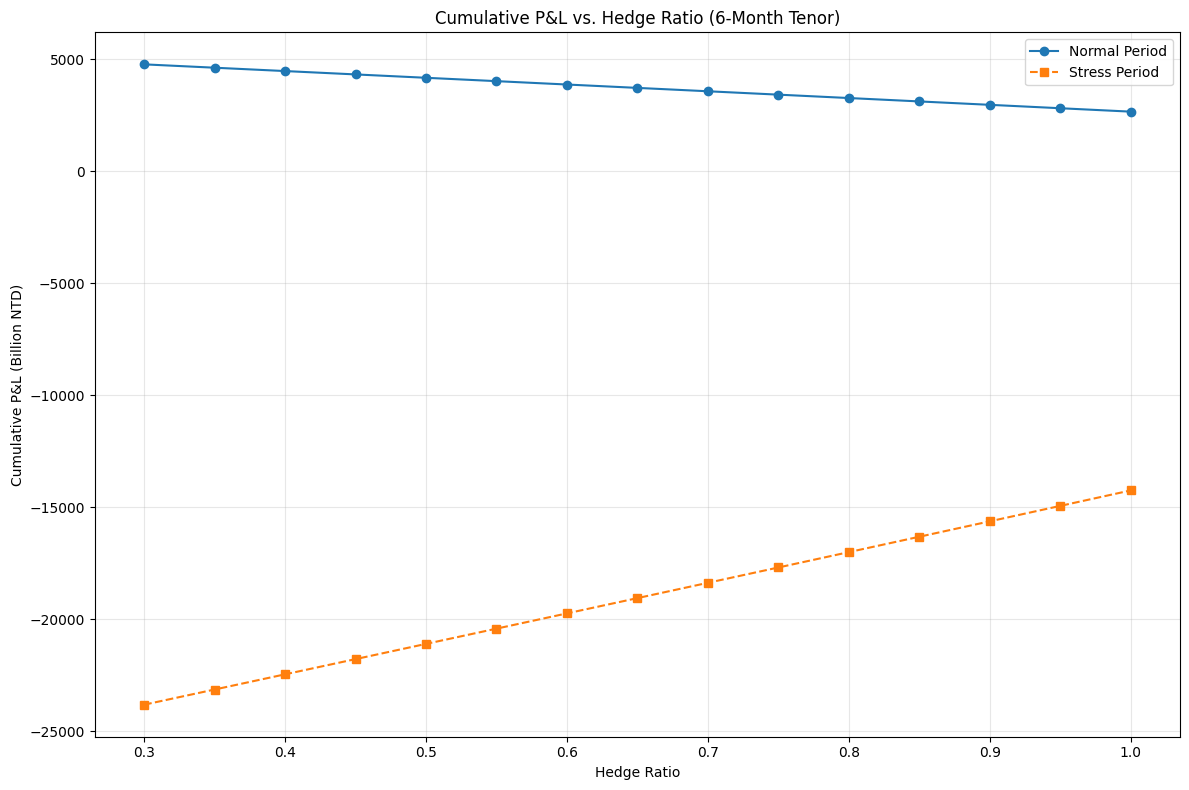

In [6]:
df_normal = df_data.loc['2021-12-10':'2025-01-01'].copy()


hedge_ratios = np.arange(0.3, 1.05, 0.05)
tenor = 6
forward_col = 'forward_6m'

# Lists to store the final cumulative P&L for each hedge ratio
normal_final_pnl = []
stress_final_pnl = []

# Loop through each hedge ratio to run the simulations
for hr in hedge_ratios:
    # Run simulation for the normal period

    insurer_model = create_insurer(f'Hedge {hr:.0%}', hr)
    history_normal = run_simulation(insurer_model, df_normal, forward_col, tenor)
   
    history_normal['Total_PnL_TWD'] = (
    history_normal['Investment_Income_TWD'] + history_normal['Net_FX_Impact']
    )

    final_pnl_normal = history_normal['Total_PnL_TWD'].sum() / 1e9
    normal_final_pnl.append(final_pnl_normal)

    # Run simulation for the stress period
    insurer_model = create_insurer(f'Hedge {hr:.0%}', hr)
    history_stress = run_simulation(insurer_model, df_stress, forward_col, tenor)

    history_stress['Total_PnL_TWD'] = (
    history_stress['Investment_Income_TWD'] + history_stress['Net_FX_Impact']
    )

    final_pnl_stress = history_stress['Total_PnL_TWD'].sum() / 1e9
    stress_final_pnl.append(final_pnl_stress)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(hedge_ratios, normal_final_pnl, 'o-', label='Normal Period')
plt.plot(hedge_ratios, stress_final_pnl, 's--', label='Stress Period')
plt.xlabel('Hedge Ratio')
plt.ylabel('Cumulative P&L (Billion NTD)')
plt.title('Cumulative P&L vs. Hedge Ratio (6-Month Tenor)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Average pnl over period, x axis would be the ratio nad y as the returns
 

In [7]:
# Find the best performing hedge ratio for each period
best_normal_ratio_index = np.argmax(normal_final_pnl)
best_normal_ratio = hedge_ratios[best_normal_ratio_index]
best_normal_pnl = normal_final_pnl[best_normal_ratio_index]

best_stress_ratio_index = np.argmax(stress_final_pnl)
best_stress_ratio = hedge_ratios[best_stress_ratio_index]
best_stress_pnl = stress_final_pnl[best_stress_ratio_index]

# Print the results for analysis
print(f"Hedge Ratios: {hedge_ratios.tolist()}")
print(f"Normal Period Final P&L (Billion NTD): {normal_final_pnl}")
print(f"Stress Period Final P&L (Billion NTD): {stress_final_pnl}")
print(f"Best performing hedge ratio under normal period is {best_normal_ratio:.0%} with a final P&L of {best_normal_pnl:.2f} Billion NTD.")
print(f"Best performing hedge ratio under stress period is {best_stress_ratio:.0%} with a final P&L of {best_stress_pnl:.2f} Billion NTD.")

Hedge Ratios: [0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.5999999999999999, 0.6499999999999999, 0.7, 0.7499999999999999, 0.7999999999999998, 0.8499999999999999, 0.8999999999999999, 0.9499999999999998, 0.9999999999999998]
Normal Period Final P&L (Billion NTD): [np.float64(4770.114850735555), np.float64(4620.416345584314), np.float64(4470.613479027302), np.float64(4320.691342292265), np.float64(4170.635026606952), np.float64(4020.4296231991084), np.float64(3870.0602232964843), np.float64(3719.5119181268224), np.float64(3568.7697989178732), np.float64(3417.8189568973808), np.float64(3266.6444832930974), np.float64(3115.2314693327617), np.float64(2963.5650062441277), np.float64(2811.6301852549404), np.float64(2659.4120975929472)]
Stress Period Final P&L (Billion NTD): [np.float64(-23812.54498810243), np.float64(-23134.88018575996), np.float64(-22456.678188658203), np.float64(-21777.862254688705), np.float64(-21098.355641742994), np.float